In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import importlib
import pandas as pd
import numpy as np
from typing import Optional

import allib
from allib.models.al import ActiveLearningPipeline, RandomMetric, UncertainMetric
from allib.datasets import get_uci_db, load_uci, Dataset
from allib.metrics import get_metrics

from sklearn import preprocessing
from tqdm.notebook import tqdm 
from catboost import CatBoostClassifier, to_classifier, sum_models
importlib.reload(allib)

<module 'allib' from '/Users/jecosine/Courses/COMP8800/Projects/CatBoostTutorial/allib/__init__.py'>

In [10]:
def make_model() -> CatBoostClassifier:
        return CatBoostClassifier(
            iterations=5,
            learning_rate=0.1,
            # loss_function='CrossEntropy'
        )
        # model.classes_ = 3
class CatBoostPPL(ActiveLearningPipeline):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.model_list = []
    
    
    def run(self, n_iter: Optional[int]=None):
        prog = tqdm(self.dataset, total=len(self.dataset))
        prog.set_description(f"The {n_iter+1}th run:")
        for tx, ty in prog:
            new_model = self.model if not self.model_list else make_model()
            new_model.fit(tx, ty, verbose=False)
            self.model_list.append(new_model)
            self.model = self.model_list[0] if len(self.model_list) == 1 else to_classifier(sum_models(self.model_list, weights=[1.0 / len(self.model_list)] * len(self.model_list)))
            self.apply_eval_metrics()
        self.model_list = []
        self.model = make_model()

In [11]:
uci_db = get_uci_db()
print(len(uci_db))

614


In [12]:
data, label = load_uci("iris")

In [13]:
le = preprocessing.LabelEncoder()
le.fit(label)
label = le.transform(label)

In [14]:
SEED = 42
params = {
    "random_state": SEED,
    "init_size": 3,
    "batch_size": 20
}
random_metric = RandomMetric()
uncertain_metric = UncertainMetric()
rand_dataset = Dataset(data, label, al_metric=random_metric, shuffle=False, **params)
uncert_dataset = Dataset(data, label, al_metric=uncertain_metric, shuffle=False, **params)

In [15]:
model = make_model()
ppl = CatBoostPPL(model=model, dataset=rand_dataset, eval_metrics=get_metrics(["accuracy"]), n_times=10)

In [16]:
ppl.start()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [19]:
import matplotlib.pyplot as plt

In [20]:
x = np.array(ppl.stats[0]["instances"])
acc = np.vstack([ppl.stats[i]["accuracy"] for i in range(5)])
acc_mean = acc.mean(axis=0)
acc_max = acc.max(axis=0)
acc_min = acc.min(axis=0)

(0.0, 1.0)

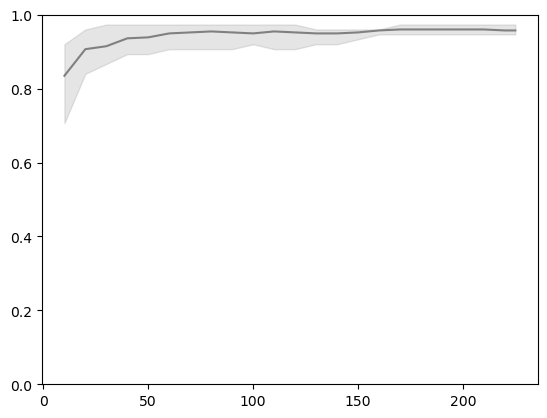

In [21]:
plt.plot(x, acc_mean, '-', color='gray')
plt.fill_between(x, acc_min, acc_max,
                 color='gray', alpha=0.2)
plt.ylim(0, 1)

AttributeError: 'function' object has no attribute '_score_func'